In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import json

In [ ]:
!pip install folium
import folium

In [ ]:
# ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import xgboost as xgb

# Clustering
import hdbscan

/usr/local/lib/python3.12/dist-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [ ]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


In [ ]:
def haversine(lat1, lon1, lat2, lon2):
    """Calculate haversine distance in km between two lat/lon points"""
    R = 6371
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    return 2 * R * asin(sqrt(a))

def add_time_features(df):
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['is_rush'] = df['hour'].isin([7,8,17,18,19]).astype(int)
    return df

In [ ]:
traffic_df = pd.read_csv('/content/drive/MyDrive/DA_Project/cleaned/traffic_feb2024_sample.csv')

stops_df = pd.read_csv('/content/drive/MyDrive/DA_Project/cleaned/cleaned_bus_stops_file.csv')
routes_df = pd.read_csv('/content/drive/MyDrive/DA_Project/cleaned/cleaned_bus_routes_file.csv')

print("Traffic data shape:", traffic_df.shape)
print("Bus stops:", len(stops_df))
print("Bus routes:", len(routes_df))
print("\nFirst few traffic records:")
traffic_df.head(10)

Traffic data shape: (1549600, 9)
Bus stops: 4674
Bus routes: 578

First few traffic records:


,VehicleID,gpsvalid,lat,lon,timestamp,speed,heading,for_hire_light,engine_acc
0,jMeH1+Sj7iNsqnwTrvnZfXHHtpQ,1,13.59135,100.36354,2024-02-05 04:21:20,0,174,0,0
1,BfHt2c4llhPSRk2f2RG4rTmiY8c,1,13.80487,100.77665,2024-02-28 04:58:35,0,265,0,1
2,IZyH325Y+JZVTFVXpu8DOH7W+k0,1,13.84252,100.59600,2024-02-10 00:51:56,52,238,0,1
3,+GhFxxWT40SCdITkluimODLYa9M,1,13.69183,100.39158,2024-02-08 01:38:28,0,23,0,0
4,pCdQD88dmxbIQAjWwrPbypJP6Kg,1,13.85963,100.67261,2024-02-25 13:46:40,0,354,0,1
5,nZmRtsZR/0F1IT7xwf017xi6tPg,1,13.70790,100.53185,2024-02-14 14:59:38,0,170,0,0
6,R2MHbgqGXCDY16u4+dUTDOuOc7s,1,13.76811,100.54038,2024-02-24 12:13:28,37,207,1,1
7,YmM8Kpr3sKCy8VHfpm6grWSc5Wg,1,13.94994,100.65225,2024-02-28 21:38:36,23,277,0,0
8,9SUwJqcQRiSiJrxbmo9+7lHKGTQ,1,13.77616,100.57373,2024-02-26 20:44:56,21,182,0,1
9,Ck2qN/yb5a98ANdnHPT2W4RoHgs,1,13.70238,100.60251,2024-02-09 21:25:36,50,334,0,1


In [ ]:
stops_df.head()

,bsid,refname,lat,lon
0,1,Saran Rom Palace,13.747348,100.495689
1,2,Wangburapa,13.745549,100.502711
2,5,Wat chong lom,13.702836,100.545884
3,10,sen chon school,13.809688,100.560051
4,11,Children Hospital,13.766231,100.535158


In [ ]:
traffic_df.isnull().sum()

,0
VehicleID,0
gpsvalid,0
lat,0
lon,0
timestamp,0
speed,0
heading,0
for_hire_light,0
engine_acc,0


In [ ]:
traffic_df.describe()

,gpsvalid,lat,lon,speed,heading,for_hire_light,engine_acc
count,1549600.0,1.549600e+06,1.549600e+06,1.549600e+06,1.549600e+06,1.549600e+06,1.549600e+06
mean,1.0,1.377138e+01,1.005638e+02,1.309453e+01,1.772869e+02,3.894224e-01,5.663397e-01
std,0.0,9.945597e-02,1.082096e-01,2.219949e+01,1.053436e+02,4.876195e-01,4.955797e-01
min,1.0,1.350001e+01,1.003000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.0,1.370495e+01,1.004940e+02,0.000000e+00,8.900000e+01,0.000000e+00,0.000000e+00
50%,1.0,1.376343e+01,1.005591e+02,0.000000e+00,1.810000e+02,0.000000e+00,1.000000e+00
75%,1.0,1.383996e+01,1.006361e+02,2.100000e+01,2.700000e+02,1.000000e+00,1.000000e+00
max,1.0,1.400000e+01,1.009000e+02,1.500000e+02,3.600000e+02,1.000000e+00,1.000000e+00


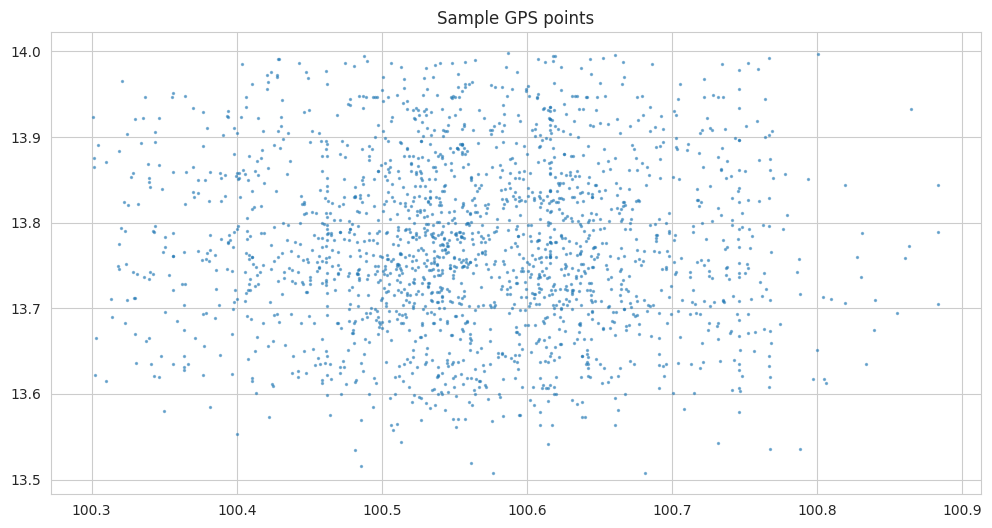

In [ ]:
plt.scatter(traffic_df['lon'].sample(2000), traffic_df['lat'].sample(2000), s=2, alpha=0.5)
plt.title("Sample GPS points")
plt.show()

In [ ]:
stops_df.isnull().sum()

,0
bsid,0
refname,0
lat,9
lon,9


In [ ]:
stops_df.dropna(inplace=True)

In [ ]:
traffic_df.head()

,VehicleID,gpsvalid,lat,lon,timestamp,speed,heading,for_hire_light,engine_acc
0,jMeH1+Sj7iNsqnwTrvnZfXHHtpQ,1,13.59135,100.36354,2024-02-05 04:21:20,0,174,0,0
1,BfHt2c4llhPSRk2f2RG4rTmiY8c,1,13.80487,100.77665,2024-02-28 04:58:35,0,265,0,1
2,IZyH325Y+JZVTFVXpu8DOH7W+k0,1,13.84252,100.59600,2024-02-10 00:51:56,52,238,0,1
3,+GhFxxWT40SCdITkluimODLYa9M,1,13.69183,100.39158,2024-02-08 01:38:28,0,23,0,0
4,pCdQD88dmxbIQAjWwrPbypJP6Kg,1,13.85963,100.67261,2024-02-25 13:46:40,0,354,0,1


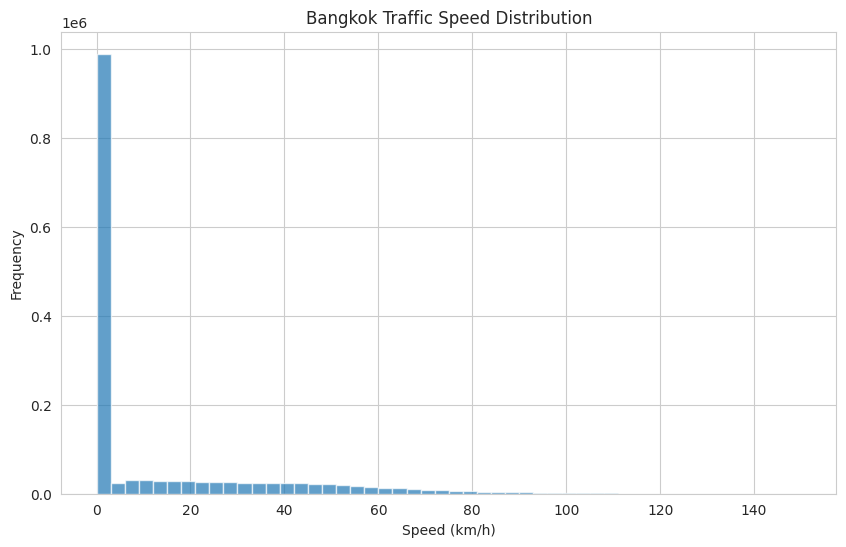

In [ ]:
plt.figure(figsize=(10,6))
traffic_df['speed'].hist(bins=50, alpha=0.7)
plt.title('Bangkok Traffic Speed Distribution')
plt.xlabel('Speed (km/h)')
plt.ylabel('Frequency')
plt.show()


In [ ]:
traffic_df['timestamp'] = pd.to_datetime(traffic_df['timestamp'])
traffic_df['hour'] = traffic_df['timestamp'].dt.hour
traffic_df['day_of_week'] = traffic_df['timestamp'].dt.dayofweek

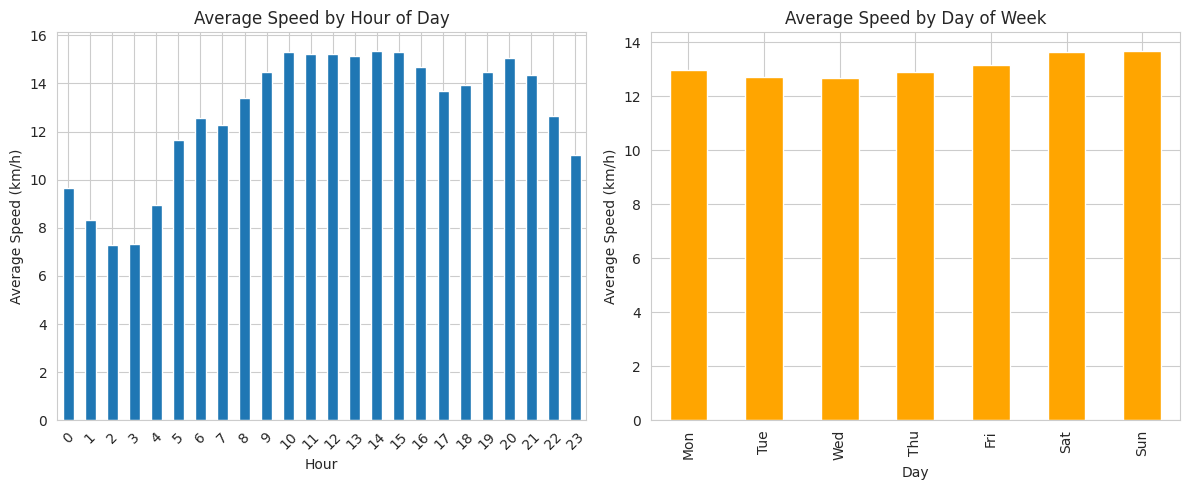

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
hourly_speed = traffic_df.groupby('hour')['speed'].mean()
hourly_speed.plot(kind='bar')
plt.title('Average Speed by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Average Speed (km/h)')
plt.xticks(rotation=45)

plt.subplot(1,2,2)
daily_speed = traffic_df.groupby('day_of_week')['speed'].mean()
days = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
daily_speed.index = days
daily_speed.plot(kind='bar', color='orange')
plt.title('Average Speed by Day of Week')
plt.xlabel('Day')
plt.ylabel('Average Speed (km/h)')

plt.tight_layout()
plt.show()